In [2]:
from numpy import dot
from numpy.linalg import norm
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import gensim   
import numpy as np  
import json


In [3]:
"""
Building indexes
"""
def merge_docs(docs):
    merged_docs = []
    for i in range(len(docs)):
        temp = []
        for j in docs[i]:
            temp.extend(j)
        merged_docs.append(temp)
    return merged_docs

def part_corpus(merged_docs):
    part_corpus = []
    for i in range(len(merged_docs)):
        temp = " "
        part_corpus.append(temp.join(merged_docs[i]))
    return part_corpus

def return_word_vectors(proc_corp, word_vocab, model):
    doc_term_matrix = []; 
    for sentence in proc_corp: 
        vector = np.zeros(50) 
        count_words =0; 
        for word in sentence.split(): 
            if word in word_vocab:
                vector += model.wv[word]
                count_words += 1
        if count_words != 0:
            vector /= count_words
        doc_term_matrix.append(vector)
    return doc_term_matrix

In [7]:
def buildIndex(docs, docIDs):

    merged_docs = merge_docs(docs)
    proc_corp = part_corpus(merged_docs)
        
    model = gensim.models.Word2Vec(proc_corp, min_count = 1, vector_size = 50, window = 5)
    word_vectors = model.wv
    word_vectors.save('vectors.kv')
    word_vocab =  set(model.wv.index_to_key)
    doc_term_matrix = return_word_vectors(proc_corp, word_vocab, model)   

    index = dict()
    for i in range(len(docIDs)):
        index[docIDs[i]] = doc_term_matrix[i]

    return index, model


In [13]:
def rank(queries, index, model):

    doc_IDs_ordered = []
    merged_queries = merge_docs(queries)
    proc_q = part_corpus(merged_queries)        
    word_vocab =  set(model.wv.index_to_key)
    doc_term_matrix = return_word_vectors(proc_q, word_vocab, model) 

    for i in range(len(doc_term_matrix)):
     
        query_vector = doc_term_matrix[i]
        doc_query_sim = dict()
        doc_order = []
  
        for j in index.keys():
            doc_vector = index[j]
            cos_sim = np.dot(np.reshape(query_vector, (1,-1)),np.reshape(doc_vector, (-1,1)))/(norm(np.reshape(query_vector, (1,-1))) * norm(np.reshape(doc_vector, (1,-1))) + 0.000000000001)           
            doc_query_sim[j] = cos_sim

        sort_orders = sorted(doc_query_sim.items(), key=lambda x: x[1], reverse=True)
        for k in sort_orders:
            doc_order.append(k[0]-1)

        doc_IDs_ordered.append(doc_order[:10])

    return doc_IDs_ordered

In [14]:
from native_preprocessor import native_prep
native_prep = native_prep()

def load_json_files():
    # Read queries
    queries_json = json.load(open(main_path + "cran_queries.json", 'r'))[:]
    query_ids, queries = [item["query number"] for item in queries_json], \
                            [item["query"] for item in queries_json]
    # Process queries 
    processedQueries = native_prep.preprocessQueries(queries)

    processedQueries = processedQueries[:]
    # print(processedQueries)

    # Read documents
    docs_json = json.load(open(main_path + "cran_docs.json", 'r'))[:]
    doc_ids, docs = [item["id"] for item in docs_json], \
                            [item["body"] for item in docs_json]
    # Process documents
    processedDocs = native_prep.preprocessDocs(docs)
    # print(processedDocs[0])

    ### to resolve num1 discrepancy:
    query_ids = list(np.array(query_ids)-1)
    doc_ids = list(np.array(doc_ids)-1)    
    return processedQueries, processedDocs, query_ids, doc_ids

proc_queries, proc_docs, query_ids, doc_ids = load_json_files()

def searchDataset(proc_docs, docIDs, proc_queries, k):
    """
    - preprocesses the queries and documents, stores in output folder
    - invokes the IR system
    
    """    
    # Build document index
    index, model = buildIndex(proc_docs, docIDs)
    # Rank the documents for each query
    doc_IDs_ordered = rank(proc_queries, index, model)
    return doc_IDs_ordered

doc_ids_ordered = searchDataset(proc_docs, doc_ids, proc_queries, 10)

# print(len(doc_ids_ordered))

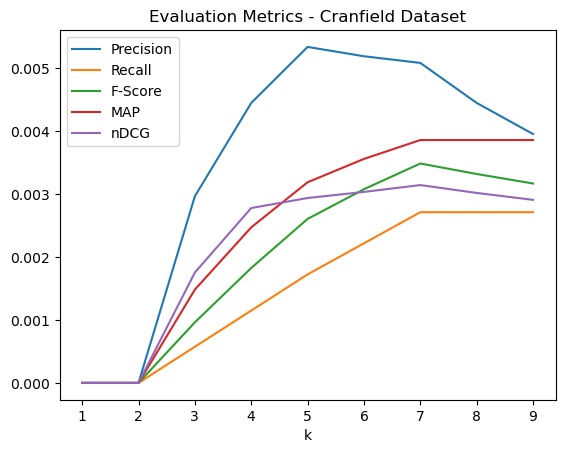

In [15]:
qrels = json.load(open(main_path + "cran_qrels.json", 'r'))[:]

from big_true_IDs import big_true_IDs
big_true_IDs_ob = big_true_IDs()
big_true_IDs = big_true_IDs_ob.big_true_IDs(qrels)  

query_ids = list(range(225))

from plotting import plotting
plot_ob = plotting()
plot_ob.plot_measures(doc_ids_ordered, query_ids, big_true_IDs, qrels, 10)

In [ ]:
### The graph displayed here is slightly different than the one in the report. Efforts were made to polish the word2vec method but they failed sadly